In [1]:
import torch
import functorch

from sngrok.permutations import Permutation, make_permutation_dataset
from sngrok.model import SnMLP
from sngrok.tableau import generate_partitions
from sngrok.irreps import SnIrrep

from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap

In [2]:
run = torch.load('checkpoints/s5_50_02/full_run.pth', map_location=torch.device('cpu'))

In [3]:
run['config']

{'embed_dim': 256, 'model_dim': 128, 'vocab_size': 120, 'tie_lr': False}

In [4]:
"""
def _dot(fx, rho):
    return fx * rho

fft_dot = functorch.vmap(scalar_x_mat, in_dims=(0, 0))

def _fft_sum(fx, rho):
    if rho.dim() == 1:
        return torch.dot(fx, rho)
    else:
        return fft_dot(fx, rho).sum(dim=0)
    
fft_sum = functorch.vmap(_fft_sum, in_dims=(1, None))


def slow_ft(fn_vals, n):
    all_partitions = generate_partitions(n)
    permutations = Permutation.full_group(n)
    #fn_vals = fn(permutations)
    all_irreps = [SnIrrep(n, p) for p in all_partitions]
    results = {}
    for irrep in all_irreps:
        matrices = irrep.matrix_tensor()
        results[irrep.shape] = fft_sum(fn_vals, matrices).squeeze()
    return results

"""

from sngrok.fourier import slow_ft, sn_fourier_basis

In [5]:
list(run.keys())

['model', 'config', 'checkpoints', 'checkpoint_epochs']

In [6]:
model = SnMLP.from_config(run['config'])
model.load_state_dict(run['model'])

<All keys matched successfully>

In [8]:

fourier_lembed = slow_ft(model.lembed.weight, 5)
fourier_lembed[(3, 1, 1)].shape

torch.Size([256, 6, 6])

In [9]:
ft_decomp_lembed = sn_fourier_basis(fourier_lembed, 5)

In [11]:
ft_decomp_lembed.shape


torch.Size([120, 7, 256])

In [12]:
reshaped_lembed = ft_decomp_lembed.reshape((-1, 256))


In [15]:
lident = ft_decomp_lembed[0]
torch.equal(lident, reshaped_lembed[0:7])

True

In [21]:
import einops



tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])

In [33]:
import polars as pl
import math


def fourier_basis_to_df(tensor, n):
    group_order, num_irreps, fn_dim = tensor.shape
    all_partitions = generate_partitions(n)
    permutations = Permutation.full_group(n)
    assert len(permutations) == group_order
    assert len(all_partitions) == num_irreps
    
    long_values = tensor.reshape((-1, fn_dim))
    group_col= []
    for s in permutations:
        group_col += [str(s.sigma)] * num_irreps
    part_col = [str(p) for p in all_partitions] * group_order
    assert len(group_col) == len(part_col) and len(group_col) == long_values.shape[0]
    val_data = pl.DataFrame(long_values.detach().numpy(), schema=[f'dim{i}' for i in range(fn_dim)])
    sn_metadata = pl.DataFrame({'permutation': group_col, 'irrep': part_col})
    return pl.concat([sn_metadata, val_data], how='horizontal')

lembed_df = fourier_basis_to_df(ft_decomp_lembed, 5)
lembed_df.head()

permutation,irrep,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32,dim33,dim34,...,dim219,dim220,dim221,dim222,dim223,dim224,dim225,dim226,dim227,dim228,dim229,dim230,dim231,dim232,dim233,dim234,dim235,dim236,dim237,dim238,dim239,dim240,dim241,dim242,dim243,dim244,dim245,dim246,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,...,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""(0, 1, 2, 3, 4...","""(1, 1, 1, 1, 1...",-0.156939,-0.227466,0.087732,0.156965,-0.128979,0.098811,0.027995,0.036726,0.227116,0.038665,-0.00369,0.00871,-0.190716,0.152936,0.21238,-0.214196,0.030951,-0.111627,-0.110501,-0.034598,-0.192036,0.023126,-0.412126,-0.114008,-0.292841,0.259591,0.085904,0.19708,0.474567,0.067753,0.237591,-0.018286,-0.26221,-0.325021,0.134981,...,-0.299829,-0.074539,-0.03563,0.070744,0.087062,-0.020902,-0.061622,0.122837,0.114011,-0.044059,-0.130871,-0.07263,-0.028401,0.004336,-0.07463,-0.024694,-0.072315,0.040199,-0.048562,-0.226973,0.09772,0.079783,0.231914,0.034608,-0.180568,0.12513,-0.025879,-0.195229,-0.071003,0.039467,-0.186864,0.2897,0.211167,0.00161,0.055233,-0.181147,0.286031
"""(0, 1, 2, 3, 4...","""(2, 1, 1, 1)""",-6.842973,4.044824,-7.580968,0.037305,-3.942723,0.031595,-2.603224,-0.437538,-9.569466,0.67323,8.804252,-1.744477,3.025674,-5.466168,2.685597,-4.013221,-5.759187,-5.148418,-0.295123,0.347296,-5.217764,-2.17858,4.831579,7.914421,-1.308774,1.708219,6.777381,-5.797256,3.658164,-6.887947,-6.928967,1.199583,5.039276,-0.804532,-0.267252,...,7.129307,0.427042,0.696598,-4.646136,2.820676,-4.006153,-1.549435,-6.474027,0.238288,-3.831786,5.955845,-0.382505,-2.486235,1.169927,-8.381307,-0.203973,-2.608344,6.391847,-5.683714,2.721699,-0.116665,-2.97648,-5.013349,3.464963,-0.08757,5.759881,-7.945421,3.954034,1.813573,5.409542,-0.962297,4.130421,-1.254878,-2.709643,-7.960359,2.968906,-2.118967
"""(0, 1, 2, 3, 4...","""(2, 2, 1)""",0.563898,-0.376961,-0.305081,-1.130039,-0.838077,-0.856229,-0.721701,0.098693,0.349547,0.50393,1.108834,0.133459,0.823522,-0.127442,-1.491555,-1.291893,-0.178563,0.099998,-0.81848,-0.17927,0.332179,1.122595,0.314422,-0.686779,-0.265607,0.310882,-0.116149,-1.251246,-0.352119,0.017747,0.751593,-1.311334,1.235086,0.830485,0.240328,...,-0.519931,0.050108,-0.380819,-0.0762,0.672125,-0.489037,-0.118313,-1.551887,0.3785,-1.088479,0.247937,-0.292804,-0.821076,1.034543,-0.313911,-0.063279,-0.1199,0.288086,0.388054,0.238542,-0.70065,1.308803,0.306678,1.37213,-0.106654,1.069446,0.315371,-0.236518,-0.04697,0.602429,-1.454304,-0.079891,-0.364713,0.730056,1.03616,0.450152,-0.858346
"""(0, 1, 2, 3, 4...","""(3, 1, 1)""",0.034046,0.277547,0.325305,0.133025,-0.009521,-0.052684,-0.057944,0.151107,0.335305,0.269895,-0.11231,-0.156293,-0.043703,-0.115688,0.143524,-0.509033,0.129091,0.102531,-0.261615,0.02155,-0.189598,-0.086817,-0.116661,-0.062613,-0.33024,-0.154843,0.187861,0.003453,0.063658,-0.024252,-0.245809,-0.009634,0.058857,-0.072667,0.144011,...,-0.177443,-0.038175,0.434803,0.030495,-0.258858,-0.103389,0.346621,0.276772,-0.207813,-0.175618,-0.100002,-0.025409,0.343212,-0.061911,0.121765,0.041052,-0.162303,-0.211053,0.31247,-0.079977,0.07726,0.081229,-0.134847,0.323256,-0.260802,0.10777,0.118738,0.293695,0.063636,0.278597,0.012084,0.011815,0.176499,-0.124396,0.12684,0.0745,0.004824
"""(0, 1, 2, 3, 4...","""(3, 2)""",-0.833493,0.307967,-3.27977,-0.653059,-2.344295,0.71002,-1.802344,-2.925403,1.836493,2.256682,-3.492033,-2.594257,-1.634943,-0.960842,1.131141,0.324455,-2.817858,-2.798849,-1.400287,2.808039,-2.709987,-0.009841,0.297578,-2.438162,-2.822109,3.165303,-0.808926,-0.835139,3.329852,-0.456812,-2.512401,0.11304

In [34]:
#.head()

lembed_df.select(['permutation', 'irrep', 'dim0', 'dim1']).head(20)

permutation,irrep,dim0,dim1
str,str,f64,f64
"""(0, 1, 2, 3, 4...","""(1, 1, 1, 1, 1...",-0.156939,-0.227466
"""(0, 1, 2, 3, 4...","""(2, 1, 1, 1)""",-6.842973,4.044824
"""(0, 1, 2, 3, 4...","""(2, 2, 1)""",0.563898,-0.376961
"""(0, 1, 2, 3, 4...","""(3, 1, 1)""",0.034046,0.277547
"""(0, 1, 2, 3, 4...","""(3, 2)""",-0.833493,0.307967
"""(0, 1, 2, 3, 4...","""(4, 1)""",0.327888,-0.442916
"""(0, 1, 2, 3, 4...","""(5,)""",-6.635604,-6.239559
"""(0, 1, 3, 4, 2...","""(1, 1, 1, 1, 1...",-0.156939,-0.227466
"""(0, 1, 3, 4, 2...","""(2, 1, 1, 1)""",-2.63956,-6.112335


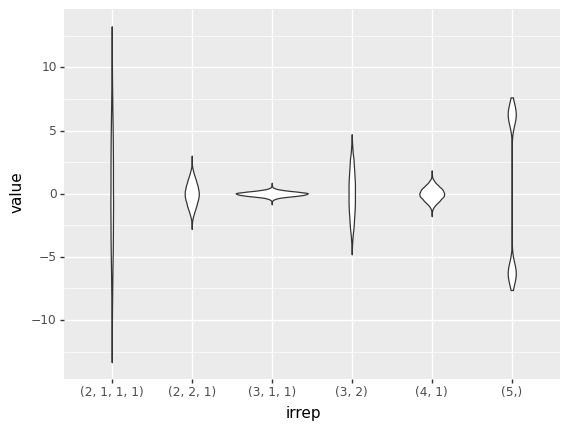

<ggplot: (360513885)>

In [35]:
from plotnine import ggplot, geom_point, geom_histogram, geom_violin, aes, stat_smooth, facet_wrap

df = lembed_df.melt(id_vars=['permutation', 'irrep']).filter(pl.col('irrep') != "(1, 1, 1, 1, 1)").to_pandas()

(
    ggplot(df, aes(x='irrep', y='value')) + geom_violin()
)

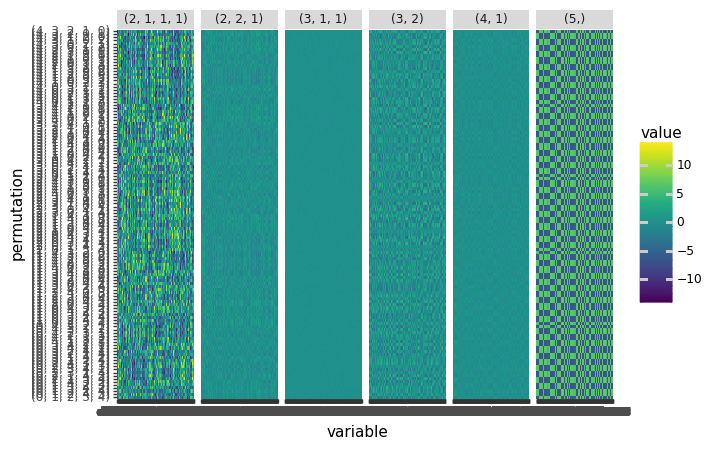

<ggplot: (723218589)>

In [41]:
from plotnine import geom_tile

(
    ggplot(df, aes(x='variable', y='permutation', fill='value')) 
    + geom_tile()
    + facet_wrap('~irrep', ncol=6)
)

In [42]:
lembed_df.melt(id_vars=['permutation', 'irrep']).head(20)

permutation,irrep,variable,value
str,str,str,f64
"""(0, 1, 2, 3, 4...","""(1, 1, 1, 1, 1...","""dim0""",-0.156939
"""(0, 1, 2, 3, 4...","""(2, 1, 1, 1)""","""dim0""",-6.842973
"""(0, 1, 2, 3, 4...","""(2, 2, 1)""","""dim0""",0.563898
"""(0, 1, 2, 3, 4...","""(3, 1, 1)""","""dim0""",0.034046
"""(0, 1, 2, 3, 4...","""(3, 2)""","""dim0""",-0.833493
"""(0, 1, 2, 3, 4...","""(4, 1)""","""dim0""",0.327888
"""(0, 1, 2, 3, 4...","""(5,)""","""dim0""",-6.635604
"""(0, 1, 3, 4, 2...","""(1, 1, 1, 1, 1...","""dim0""",-0.156939
"""(0, 1, 3, 4, 2...","""(2, 1, 1, 1)""","""dim0""",-2.63956


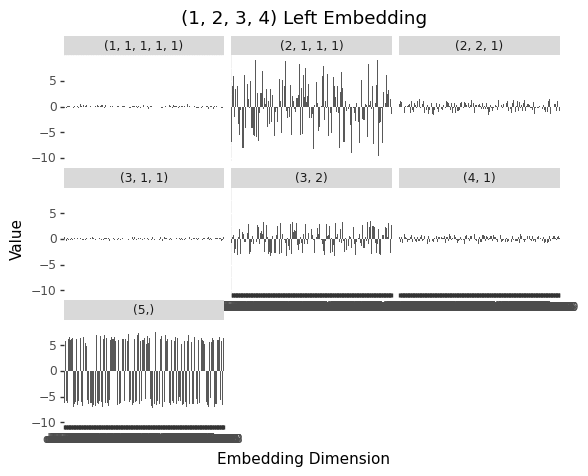

<ggplot: (360479751)>

In [55]:
from plotnine import geom_col, xlab, ylab, ggtitle

#df = lembed_df.melt(id_vars=['permutation', 'irrep']).filter((
    #pl.col('permutation') =="(0, 1, 2, 3, 4)") | (pl.col('permutation') == "(1, 0, 2, 3, 4)")
#).to_pandas()
df = lembed_df.melt(id_vars=['permutation', 'irrep']).filter((
    pl.col('permutation') =="(0, 1, 2, 3, 4)")
).to_pandas()


(
    ggplot(df, aes(x='variable', y='value')) + geom_col() + facet_wrap('~irrep') + xlab('Embedding Dimension') + ylab('Value') + ggtitle('(1, 2, 3, 4) Left Embedding')
)

In [62]:
def make_embed_barplot(data, perm, title_prefix):
    df = data.melt(id_vars=['permutation', 'irrep']).filter((
        pl.col('permutation') == str(perm.sigma))
    ).to_pandas()
    return (
        ggplot(df, aes(x='variable', y='value')) 
        + geom_col()
        + facet_wrap('~irrep') 
        + xlab('Embedding Dimension')
        + ylab('Value')
        + ggtitle(f'{title_prefix}: {str(perm.sigma)}')
    )

S5 = Permutation.full_group(5)


In [59]:
''.join([str(i) for i in (0, 1, 2, 3, 4)])

'01234'

In [64]:
for perm in S5:
    plot = make_embed_barplot(lembed_df, perm, 'Left Embed')
    filename = ''.join([str(i) for i in perm.sigma]) + '.png'
    plot.save(f'plots/lembed_dist/{filename}', verbose=False)

In [65]:
fourier_rembed = slow_ft(model.rembed.weight, 5)
ft_decomp_rembed = sn_fourier_basis(fourier_rembed, 5)
rembed_df = fourier_basis_to_df(ft_decomp_rembed, 5)


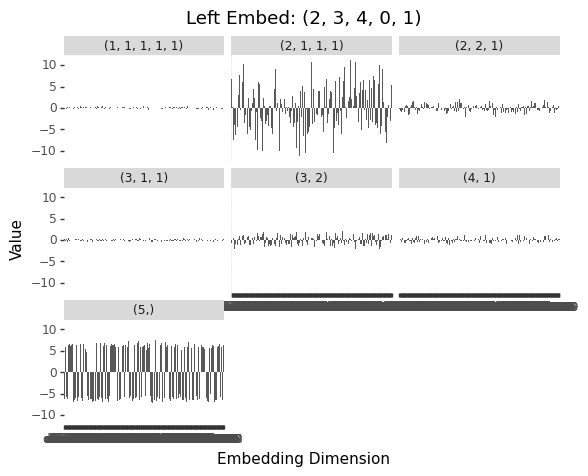

<ggplot: (706798049)>

In [67]:
make_embed_barplot(lembed_df, S5[32], 'Left Embed')

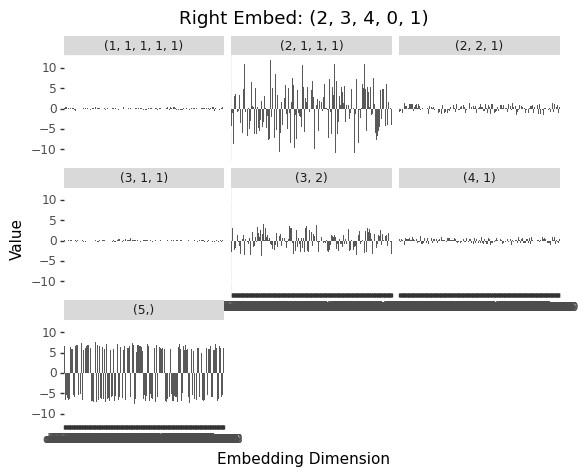

<ggplot: (712074895)>

In [66]:
make_embed_barplot(rembed_df, S5[32], 'Right Embed')

In [71]:
perms = [str(p.sigma) for p in S5]
parities = ['odd' if p.parity else 'even' for p in S5]
conj_class = [str(p.conjugacy_class) for p in S5]
s5_df = pl.DataFrame({'permutation': perms, 'parity': parities, 'conjugacy_class': conj_class})


In [73]:
full_lembed = lembed_df.join(s5_df, on='permutation', how='inner')

In [87]:
df = (
    full_lembed
    .melt(id_vars=['permutation', 'irrep', 'parity', 'conjugacy_class'])
    .pivot(index=['permutation', 'parity', 'conjugacy_class', 'variable'], columns='irrep', values='value')
    .with_columns(pl.col('variable').str.lstrip('dim').str.parse_int(radix=10).alias('embed_dim'))
    
)

df.head(50)

permutation,parity,conjugacy_class,variable,"(1, 1, 1, 1, 1)","(2, 1, 1, 1)","(2, 2, 1)","(3, 1, 1)","(3, 2)","(4, 1)","(5,)",embed_dim
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,i32
"""(0, 1, 2, 3, 4...","""even""","""(1, 1, 1, 1, 1...","""dim0""",-0.156939,-6.842973,0.563898,0.034046,-0.833493,0.327888,-6.635604,0
"""(0, 1, 3, 4, 2...","""even""","""(3, 1, 1)""","""dim0""",-0.156939,-2.63956,1.113845,-0.036829,-2.495334,0.106469,-6.635604,0
"""(0, 1, 4, 2, 3...","""even""","""(3, 1, 1)""","""dim0""",-0.156939,6.966103,0.658711,-0.382375,2.867841,0.188975,-6.635604,0
"""(0, 2, 1, 4, 3...","""even""","""(2, 2, 1)""","""dim0""",-0.156939,-3.973511,-0.737551,-0.003962,-0.472371,0.459028,-6.635604,0
"""(0, 2, 3, 1, 4...","""even""","""(3, 1, 1)""","""dim0""",-0.156939,-9.281008,-1.180313,0.155703,2.233769,0.286669,-6.635604,0
"""(0, 2, 4, 3, 1...","""even""","""(3, 1, 1)""","""dim0""",-0.156939,-1.032383,-0.733263,-0.013796,0.240196,0.58493,-6.635604,0
"""(0, 3, 1, 2, 4...","""even""","""(3, 1, 1)""","""dim0""",-0.156939,-1.071474,1.021688,0.121867,1.217369,0.676228,-6.635604,0
"""(0, 3, 2, 4, 1...","""even""","""(3, 1, 1)""","""dim0""",-0.156939,-6.752255,-0.185064,-0.096213,0.632309,0.494976,-6.635604,0
"""(0, 3, 4, 1, 2...","""even""","""(2, 2, 1)""","""dim0""",-0.156939,0.036093,-0.081979,-0.353553,-2.278354,0.268098,-6.635604,0


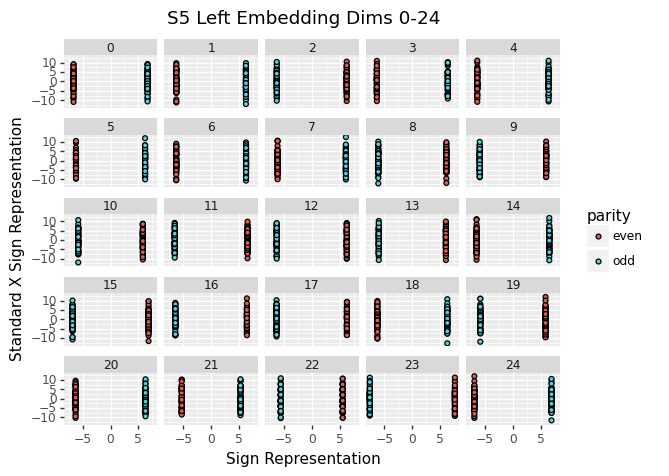

<ggplot: (705149292)>

In [107]:




filtered_df = df.filter(pl.col('conjugacy_class') != '(1, 1, 1, 1, 1)').filter(pl.col('embed_dim') < 25) #.filter(pl.col('embed_dim') > )

(ggplot(
    filtered_df.to_pandas(),
    aes(x='(5,)', y='(2, 1, 1, 1)', fill='parity')) 
 + geom_point() 
 + facet_wrap('~embed_dim', nrow=5)
 + xlab('Sign Representation')
 + ylab('Standard X Sign Representation')
 + ggtitle('S5 Left Embedding Dims 0-24')
)


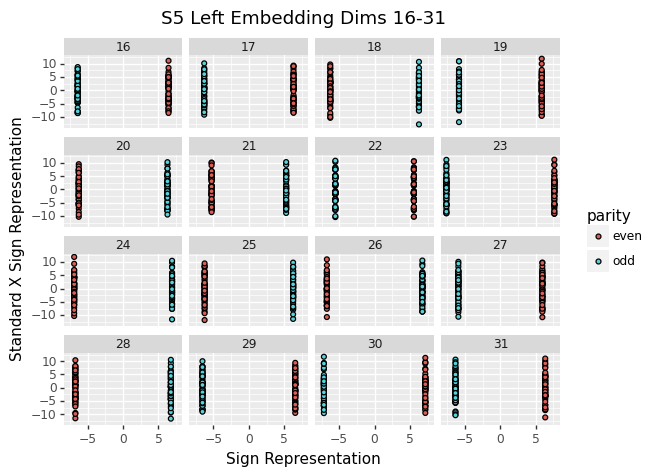

<ggplot: (704915679)>

In [108]:
def make_embed_scatterplot(data, mindim, maxdim):
    filtered_df = data.filter(
        pl.col('conjugacy_class') != '(1, 1, 1, 1, 1)'
    ).filter(pl.col('embed_dim') < maxdim).filter(pl.col('embed_dim') >= mindim)

    return (ggplot(
        filtered_df.to_pandas(),
        aes(x='(5,)', y='(2, 1, 1, 1)', fill='parity')) 
     + geom_point() 
     + facet_wrap('~embed_dim', nrow=4)
     + xlab('Sign Representation')
     + ylab('Standard X Sign Representation')
     + ggtitle(f'S5 Left Embedding Dims {mindim}-{maxdim - 1}')
    )

make_embed_scatterplot(df, 16, 32)

In [111]:
for mindim in range(0, 256, 16):
    plot = make_embed_scatterplot(df, mindim, mindim+16)
    fname = f'dims{mindim}-{mindim+15}.png'
    plot.save(f'plots/lembed_scatter/{fname}')

/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plots/lembed_scatter/dims0-15.png
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plots/lembed_scatter/dims16-31.png
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plots/lembed_scatter/dims32-47.png
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.

In [112]:
out, cache = model.run_with_cache(torch.tensor(0), torch.tensor(0))

In [113]:
x, y = torch.cartesian_prod(torch.arange(0, 120), torch.arange(0, 120)).hsplit(2)
x, y = x.squeeze(), y.squeeze()
out, cache = model.run_with_cache(x, y)

In [114]:
labels = torch.argmax(out, dim=1)

In [115]:
inverse_idx = torch.where(labels == 0)[0]

In [14]:
list(cache.keys())

['hook_lembed', 'hook_rembed', 'hook_linear', 'hook_unembed']

In [117]:
from torch.nn.functional import relu

linear_activations = relu(cache['hook_linear'])


In [119]:
perms, mult_df = make_permutation_dataset(5)

In [ ]:
from polars import 

In [152]:
from operator import add
from functools import reduce
#mult_df['permutation_left'].apply(lambda x: reduce(add, [str(i) for i in x]))
#mult_df['permutation_left'].arr.eval(pl.element().cast(str)).arr.join('')

mult_df.columns

['index_left',
 'permutation_left',
 'cycle_rep_left',
 'conjugacy_class_left',
 'parity_left',
 'index_right',
 'perm_right',
 'cycle_rep_right',
 'conjugacy_class_right',
 'parity_right',
 'permutation_target',
 'index_target',
 'conjugacy_class_target']

In [157]:
def list2str(x):
    strings = []
    for y in x:
        strings.append(''.join([str(i) for i in y]))
    return tuple(strings)
    
mult_df.with_columns([
    pl.col('permutation_left').arr.eval(pl.element().cast(str)).arr.join(''),
    pl.col('perm_right').arr.eval(pl.element().cast(str)).arr.join(''),
    pl.col('permutation_target').arr.eval(pl.element().cast(str)).arr.join(''),
    pl.col('conjugacy_class_left').arr.eval(pl.element().cast(str)).arr.join(''),
    pl.col('conjugacy_class_right').arr.eval(pl.element().cast(str)).arr.join(''),
    pl.col('conjugacy_class_target').arr.eval(pl.element().cast(str)).arr.join('')
]).head()


index_left,permutation_left,cycle_rep_left,conjugacy_class_left,parity_left,index_right,perm_right,cycle_rep_right,conjugacy_class_right,parity_right,permutation_target,index_target,conjugacy_class_target
i32,str,object,str,i64,i32,str,object,str,i64,str,i32,str
0,"""01234""","[(4,), (3,), (2,), (1,), (0,)]","""11111""",0,0,"""01234""","[(4,), (3,), (2,), (1,), (0,)]","""11111""",0,"""01234""",0,"""11111"""
0,"""01234""","[(4,), (3,), (2,), (1,), (0,)]","""11111""",0,1,"""01342""","[(2, 4, 3), (1,), (0,)]","""311""",0,"""01342""",1,"""311"""
0,"""01234""","[(4,), (3,), (2,), (1,), (0,)]","""11111""",0,2,"""01423""","[(2, 3, 4), (1,), (0,)]","""311""",0,"""01423""",2,"""311"""
0,"""01234""","[(4,), (3,), (2,), (1,), (0,)]","""11111""",0,3,"""02143""","[(3, 4), (1, 2), (0,)]","""221""",0,"""02143""",3,"""221"""
0,"""01234""","[(4,), (3,), (2,), (1,), (0,)]","""11111""",0,4,"""02314""","[(1, 3, 2), (4,), (0,)]","""311""",0,"""02314""",4,"""311"""


In [121]:
mult_df.select(['index_left', 'index_right', 'index_target']).head(50)

index_left,index_right,index_target
i32,i32,i32
0,0,0
0,1,1
0,2,2
0,3,3
0,4,4
0,5,5
0,6,6
0,7,7
0,8,8


In [122]:
linear_activations.shape

torch.Size([14400, 128])

In [60]:
linear_df = pd.DataFrame(ident_linear.numpy())
linear_df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.002089,0.000000,0.000715,2.876616,0.000000,0.000229,4.150613,0.000000,0.000054,0.000047,...,0.000000,0.000000,1.047771,3.555363,1.528522,0.000000,0.000000,3.368933,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.012944,0.000000,0.000000,5.994815,0.000663,0.001536,...,2.696643,0.482357,0.000000,0.000000,1.529670,3.546854,0.379890,3.368501,1.020660,2.876663
2,0.003523,0.000000,0.000402,0.000000,0.000000,0.000065,1.536906,0.000000,0.000000,0.000246,...,0.000000,1.107533,0.000000,0.000000,4.125823,0.000000,0.868271,6.039986,0.000000,0.000000
3,0.000000,0.000573,0.000669,1.721225,0.001140,0.000000,0.000000,0.000000,0.000000,0.000283,...,0.000000,8.248049,0.000000,0.000000,4.090522,5.082184,6.459482,6.002008,0.000000,0.000000
4,0.000000,0.000000,0.000225,3.304460,0.000000,0.002392,1.536308,3.413246,0.000625,0.000282,...,9.044312,0.000000,0.457242,8.376721,0.000000,6.231646,0.000000,0.000000,0.879884,6.553003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.000000,0.001741,0.002998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.813801,3.891953,0.000000,4.483898,0.000000,0.000000,3.047458,2.922374,0.601181,0.000000
116,0.000000,0.000000,0.000000,0.000000,0.011160,0.000000,0.000000,2.170182,0.000000,0.000000,...,1.585873,2.425977,0.000000,0.000000,0.000000,3.390967,1.896817,4.720777,1.023755,0.543902
117,0.004201,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.126791,0.004153,0.000000,...,0.000000,2.556505,0.000000,2.090256,0.000000,0.000000,2.003340,4.720829,1.095226,0.000000
118,0.000000,0.000882,0.000000,3.608049,0.027663,0.001352,0.000000,0.000000,0.000239,0.000151,...,0.000000,0.000000,3.678776,0.000000,0.000000,0.000000,0.000000,6.294633,0.864256,1.245561


In [70]:
model.unembed.weight @ ident_linear[1, :]

tensor([40.1680,  4.1649, 17.6281,  8.9234, 12.2664, 16.3138, 19.9752, 20.5555,
        17.0140,  4.7080, 15.0376, 19.1882, 17.1998, 14.6809, 14.3504, 14.2262,
        17.9017, 15.0964,  7.1888, 23.4826, 17.0538, 20.6070, 12.0992, 10.6593,
        24.4055, 11.4540, 19.2921,  4.4583,  2.2153, 22.9052, 23.3848,  5.4080,
        14.7161,  3.8250, 17.1308, 18.8079, 11.6928, 15.1204, 20.8457,  6.3045,
        11.2234, 11.6823, 12.1434, 11.8954, 18.2578, 17.5687, 14.5531,  4.7022,
        22.1206,  6.3160,  8.1474,  7.5877, 14.7745, 18.8598, 18.6239,  6.6648,
        16.5482,  8.5767, 15.1027, 16.5259, 20.3565,  3.8284, 24.7058,  4.4595,
        11.0971,  5.2817,  7.5648, 20.0876, 11.1306, 14.1842,  6.9312,  7.0536,
        16.6404, 10.4555, 25.2127, 12.2404,  9.6439, 13.1589, 11.3169,  8.3722,
        15.2657, 17.2328, 23.8807, 10.3180, 20.7736, 11.5840, 24.0659,  1.5724,
        12.1428,  8.6762, 17.7761,  7.7713, 15.7814, 15.8559, 17.5567,  7.6456,
        13.2580, 19.7361,  9.1853, 15.90

In [71]:
ident_logits[1, :]

tensor([40.1715,  4.0805, 17.6060,  8.9567, 12.2844, 16.3225, 19.9671, 20.6148,
        17.0111,  4.7052, 15.0050, 19.1224, 17.2122, 14.6394, 14.3533, 14.2605,
        17.9291, 15.0975,  7.1519, 23.4838, 17.0868, 20.5803, 12.0705, 10.6966,
        24.3643, 11.4381, 19.3316,  4.4702,  2.1738, 22.9115, 23.4262,  5.3991,
        14.6678,  3.8380, 17.1409, 18.7685, 11.6520, 15.0945, 20.8899,  6.3152,
        11.2230, 11.7178, 12.1557, 11.8686, 18.2425, 17.5528, 14.5628,  4.6983,
        22.1086,  6.2854,  8.1337,  7.5489, 14.8003, 18.8460, 18.5626,  6.6595,
        16.6019,  8.5459, 15.0584, 16.5356, 20.3679,  3.8146, 24.6740,  4.5053,
        11.0944,  5.2614,  7.4835, 20.1170, 11.1465, 14.1330,  6.9131,  7.0736,
        16.6582, 10.4881, 25.2305, 12.2563,  9.5960, 13.1805, 11.3402,  8.3848,
        15.2597, 17.2774, 23.9022, 10.3036, 20.7765, 11.5998, 24.0760,  1.5225,
        12.1765,  8.7282, 17.8148,  7.7492, 15.7990, 15.8958, 17.5582,  7.6608,
        13.2764, 19.7208,  9.1858, 15.94

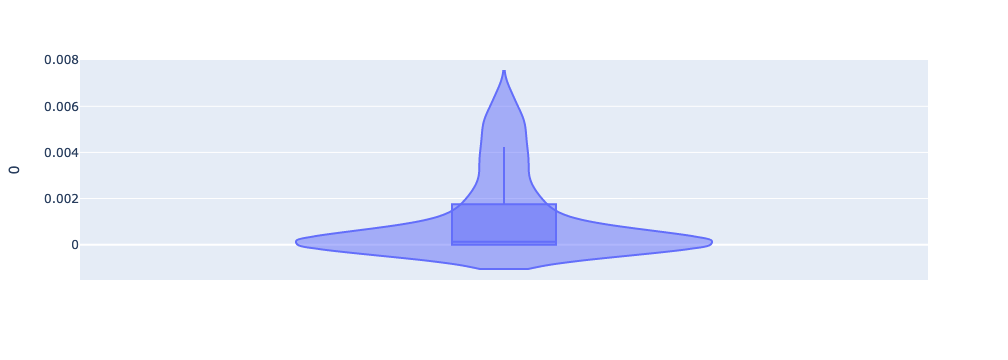

In [62]:
import plotly.express as px

fig = px.violin(linear_df, y=0, box=True, # draw box plot inside the violin
                points=False, # can be 'outliers', or False
               )
fig.show()

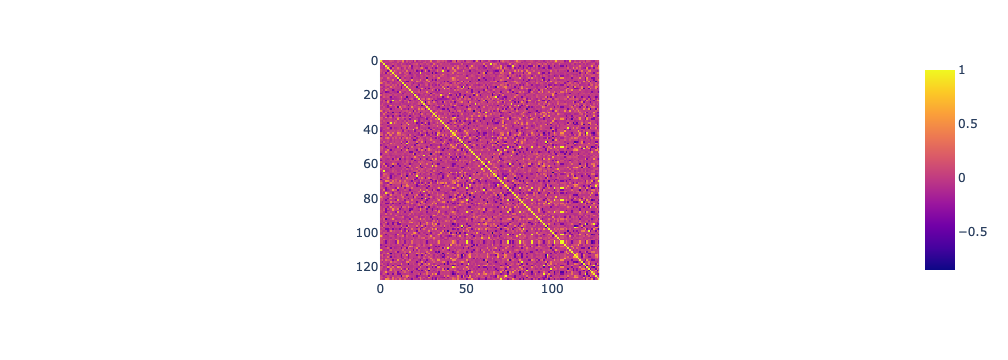

In [63]:
linear_corr = linear_df.corr()
fig = px.imshow(linear_corr)
fig.show()

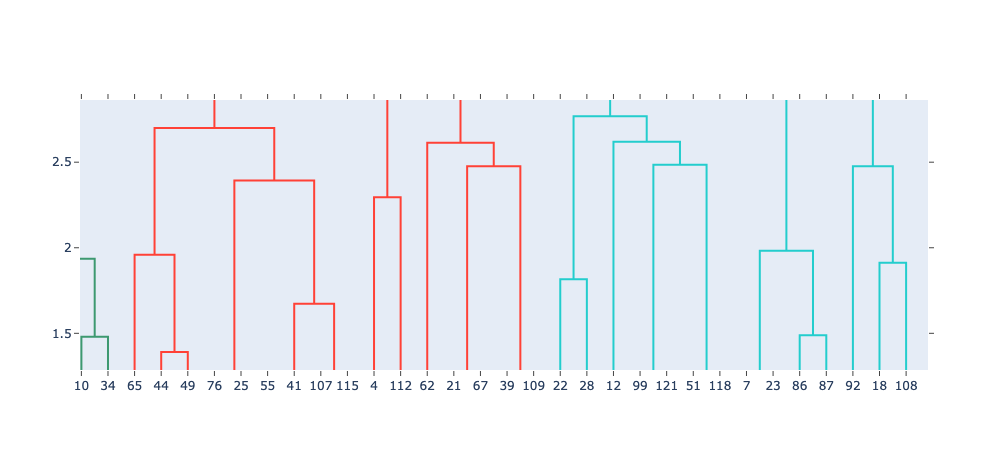

In [64]:
from plotly.figure_factory import create_dendrogram
labels = list(range(128))
dendro = create_dendrogram(linear_corr, labels = labels)
dendro.show()

In [46]:
s1 = lembed[1, :]
s2 = lembed[2, :]

In [48]:
torch.dot(s1, s1)

tensor(8.1146, grad_fn=<DotBackward0>)

In [49]:
s1.reshape((16, 16))

tensor([[-0.0798, -0.0960,  0.1077,  0.0325, -0.0825,  0.1536,  0.1722,  0.1597,
         -0.0734,  0.0152, -0.0396,  0.2561, -0.2368, -0.0884, -0.0655,  0.2594],
        [ 0.0043,  0.1241,  0.0332, -0.2043,  0.1219,  0.0890,  0.1349, -0.1033,
         -0.0418, -0.2410,  0.1115, -0.1737, -0.0058, -0.2867, -0.3058,  0.0345],
        [-0.1777, -0.2892,  0.1486, -0.0630,  0.2491, -0.2442, -0.1335, -0.0793,
         -0.2375, -0.0046,  0.3254, -0.1694,  0.3091,  0.2435, -0.2591, -0.2787],
        [ 0.3023,  0.1994,  0.0481, -0.0181,  0.2450, -0.2293, -0.0749, -0.0588,
         -0.1108,  0.0897,  0.0925,  0.2251,  0.2805, -0.1811, -0.1187,  0.0966],
        [ 0.0196,  0.0454, -0.2858,  0.0072,  0.0538, -0.0275,  0.1597, -0.2080,
         -0.1045, -0.1182, -0.1884, -0.2935, -0.1406, -0.2505, -0.3356,  0.0497],
        [-0.1343,  0.0516,  0.1694,  0.3633, -0.0699,  0.0614,  0.1990, -0.0988,
         -0.2295, -0.0517, -0.2264,  0.2857,  0.2142, -0.1709, -0.0353, -0.2892],
        [ 0.1312, -0.0